# Test different interpolations

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import scipy.special as special
import scipy.integrate as integrate
import matplotlib.pyplot as plt
# fake beta function
def special_beta(alpha, beta): return special.gamma(alpha)*special.gamma(beta)/special.gamma(alpha+beta)

In [2]:
import eko.dglap as dglap
import eko.interpolation as interpolation
import eko.mellin as mellin

In [3]:
def get_toy_pdf_x(alpha, beta):
    """test fnc in x"""
    return lambda x,alpha=alpha,beta=beta: x**alpha * (1-x)**beta
def get_toy_pdf_N(alpha, beta):
    return lambda N: special_beta(N+alpha,beta+1)

In [4]:
def get_linear_interpolators_x(x,xgrid,j):
    """get j-th linear interpolator of grid"""
    l = len(xgrid)
    if l < 2 : raise "need at least 2 points"
    if 0 == j: return (xgrid[1]-x)/(xgrid[1]) if x <= xgrid[1] else 0.
    if l - 1 == j: return (x-xgrid[-2])/(xgrid[-1] - xgrid[-2]) if x >= xgrid[-2] else 0.
    if (xgrid[j]-x)*(x-xgrid[j-1]) > 0:
        return (x-xgrid[j-1])/(xgrid[j]-xgrid[j-1])
    if (xgrid[j]-x)*(x-xgrid[j+1]) >= 0:
        return (xgrid[j+1]-x)/(xgrid[j+1]-xgrid[j])
    return 0.

In [93]:
def get_Bernstein_interpolators_x(x,g,j): # for now: keep unified function signature
    n = len(g) - 1
    return x**j * (1. - x)**(n-j) * special.binom(n,j)
def get_Bernstein_interpolators_log_x(x,g,j):
    xmin = np.min(g)
    return get_Bernstein_interpolators_x(1.-np.log(x)/np.log(xmin),g,j)
def get_Bernstein_interpolators_log_N(N,g,j):
    xmin = np.min(g)
    n = len(g) - 1
    u = 1./(N * np.log(xmin))
    if j == 0:
        return special.factorial(n) / N * u**n
    pre = np.exp(special.loggamma(1+n) - special.loggamma(1+n-j)) / N * (-u)**(n-j)
    s = 0.0
    for k in range(j+1):
        s += np.exp(special.loggamma(1+n-j+k) - special.loggamma(1+k) - special.loggamma(1+j-k)) * u**k
    return pre * s

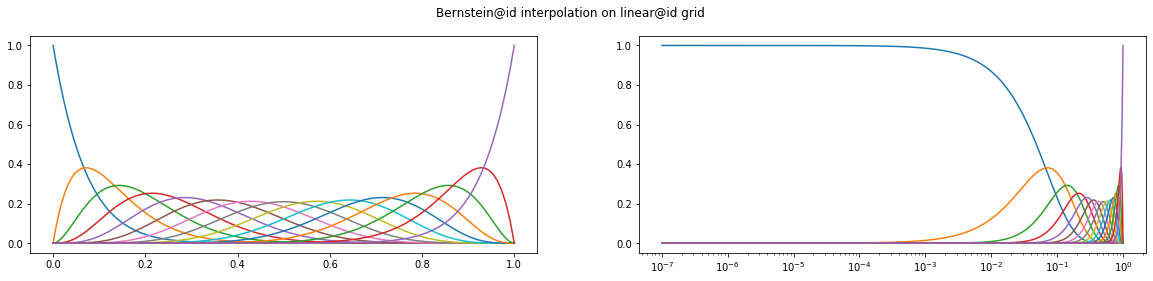

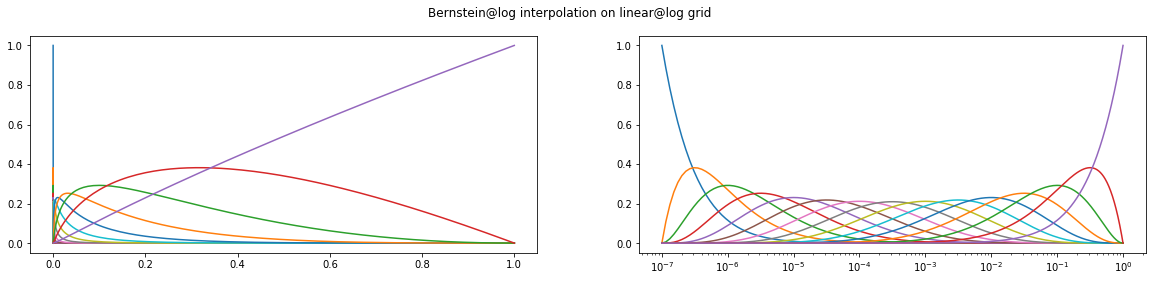

In [21]:
def plot_interpolators_x(f,g,xmin=1e-7,title=None):
    """plot all linear interpolators of grid"""
    xs = np.append(np.logspace(np.log10(xmin),-1,num=100),np.linspace(0.1,1.,num=100))
    l = len(g)
    ysl = [None] * l
    for j in range(l):
        ysl[j] = [f(x,g,j) for x in xs]
    fig = plt.figure(figsize=(20,4))
    if title is not None:
        plt.suptitle(title)
    plt.title("all interpolators p_j(x)")
    plt.subplot(1,2,1)
    for ys in ysl:
        plt.plot(xs,ys)
    plt.subplot(1,2,2)
    for ys in ysl:
        plt.semilogx(xs,ys)
    return fig

#plot_interpolators_x(get_linear_interpolators_x,[0.,.3,.5,1.],title="linear@id interpolation on custom grid")
#plot_interpolators_x(interpolation.get_Lagrange_interpolators_x,interpolation.get_xgrid_linear_at_id(4),title="Lagrange@id interpolation on linear@id grid")
#plot_interpolators_x(interpolation.get_Lagrange_interpolators_log_x,interpolation.get_xgrid_linear_at_log(4,1e-7),1e-7,title="Lagrange@log interpolation on linear@log grid")
#plot_interpolators_x(interpolation.get_Lagrange_interpolators_log_x,interpolation.get_xgrid_Chebyshev_at_log(15,1e-7),1e-7,title="Lagrange@log interpolation on Chebyshev@log grid")
plot_interpolators_x(get_Bernstein_interpolators_x,interpolation.get_xgrid_linear_at_id(15),1e-7,title="Bernstein@id interpolation on linear@id grid");
plot_interpolators_x(get_Bernstein_interpolators_log_x,interpolation.get_xgrid_linear_at_log(15,1e-7),1e-7,title="Bernstein@log interpolation on linear@log grid");

In [8]:
def plot_dist(x,y,yref,title=None):
    """compare to distributions both in linear and logarithmic x-space"""
    fig = plt.figure(figsize=(15,5))
    fig.subplots_adjust(hspace=0.05)
    if title is not None:
       fig.suptitle(title)
    # small x
    ax1 = plt.subplot(2,3,1)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.title("small x")
    plt.loglog(x,y,"o")
    plt.loglog(x,yref,"x")
    plt.subplot(2,3,4,sharex=ax1)
    plt.loglog(x,np.abs((y - yref)/yref),"x")
    plt.xlabel("x")
    # linear x
    ax2 = plt.subplot(2,3,2)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.title("linear x")
    plt.plot(x,y,"o")
    plt.plot(x,yref,"x")
    plt.subplot(2,3,5,sharex=ax2)
    plt.semilogy(x,np.abs((y - yref)/yref),"x")
    plt.xlabel("x")
    # large x
    ax3 = plt.subplot(2,3,3)
    oMx = 1.0 - x
    plt.setp(ax3.get_xticklabels(), visible=False)
    oMx_min = 1e-2
    oMx_max = 0.5
    ax3.set_xlim(oMx_min,oMx_max)
    plt.title("large x, i.e. small (1-x)")
    plt.loglog(oMx,y,"o")
    plt.loglog(oMx,yref,"x")
    ax = plt.subplot(2,3,6,sharex=ax3)
    plt.loglog(oMx,np.abs((y - yref)/yref),"x")
    plt.xlabel("1-x")
    return fig

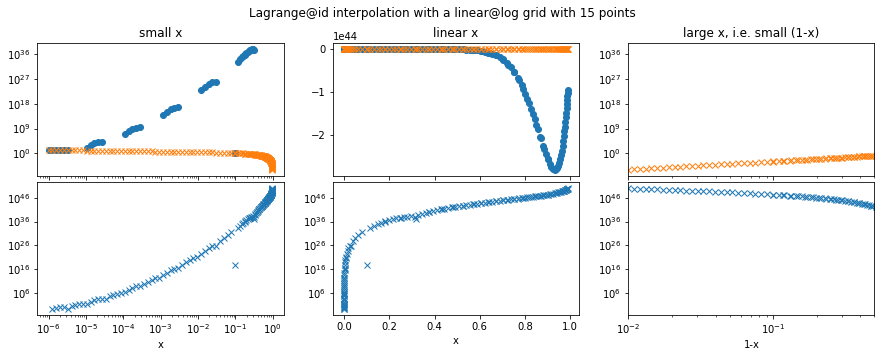

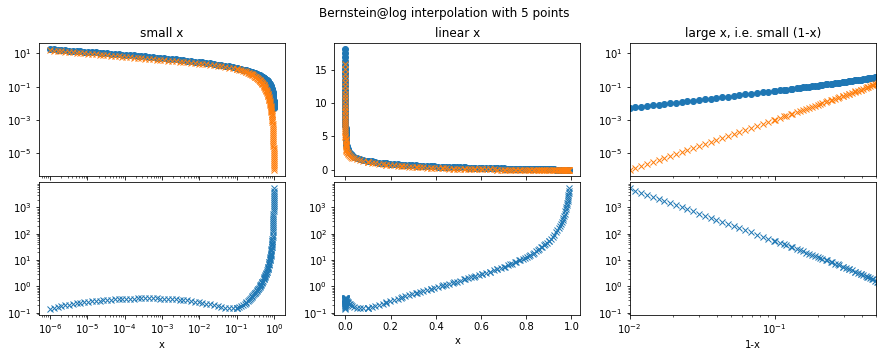

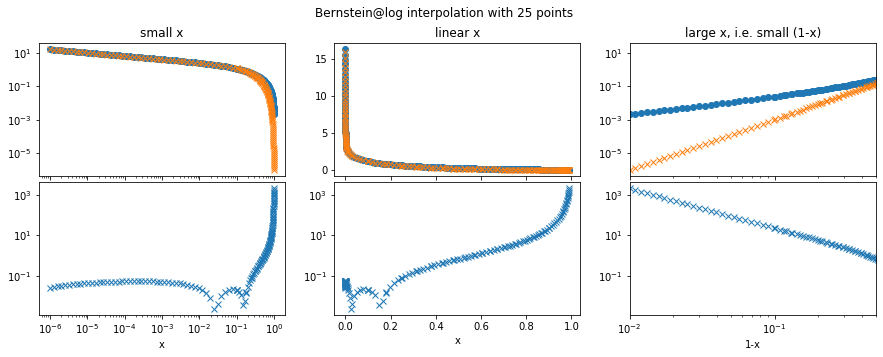

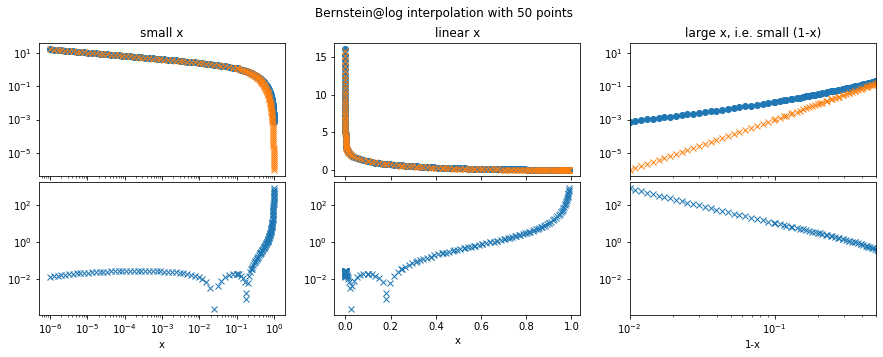

In [29]:
def test_interpolation_x(f,p,g,xmin=1e-6,title=None):
    """plots interpolation vs real thing in x"""
    fs = [f(x) for x in g]
    fp = lambda y,g=g,fs=fs: np.sum([fs[j]*p(y,g,j) for j in range(len(g))])

    oMx = 1.0 - np.logspace(-2,np.log10(.9))
    xs = np.append(np.logspace(np.log10(xmin),-1),[np.linspace(0.1,.9),oMx])
    xs = np.sort(xs)
    yref = np.array([f(x) for x in xs])
    y = np.array([fp(x) for x in xs])

    return plot_dist(xs,y,yref,title=title)

toy_alpha = -.2
toy_beta = 3.

#test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), get_linear_interpolators_x, [.01,.3,.5,1.], title="linear@id interpolation with custom grid");

#test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), interpolation.get_Lagrange_interpolators_x, [.1,.3,.5,.8,1.], title="Lagrange@id interpolation with custom grid");
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), interpolation.get_Lagrange_interpolators_x, interpolation.get_xgrid_linear_at_log(15,1e-7), title="Lagrange@id interpolation with a linear@log grid with 15 points");

#test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), get_Bernstein_interpolators_x, interpolation.get_xgrid_linear_at_id( 5,1e-7), title="Bernstein@id interpolation with 5 points");
#test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), get_Bernstein_interpolators_x, interpolation.get_xgrid_linear_at_id(25,1e-7), title="Bernstein@id interpolation with 25 points");

#test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), interpolation.get_Lagrange_interpolators_log_x, interpolation.get_xgrid_linear_at_log(7,1e-6),title="Lagrange@log-interpolation with linear@log-grid with 7 points");
#test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), interpolation.get_Lagrange_interpolators_log_x, interpolation.get_xgrid_Chebyshev_at_log(5,1e-6),title="Lagrange@log-interpolation with Chebyshev@log-grid with 5 points");
#test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), interpolation.get_Lagrange_interpolators_log_x, interpolation.get_xgrid_Chebyshev_at_log(35,1e-6),title="Lagrange@log-interpolation with Chebyshev@log-grid with 35 points");

test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), get_Bernstein_interpolators_log_x, interpolation.get_xgrid_linear_at_log(5,1e-7), title="Bernstein@log interpolation with 5 points");
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), get_Bernstein_interpolators_log_x, interpolation.get_xgrid_linear_at_log(25,1e-7), title="Bernstein@log interpolation with 25 points");
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta), get_Bernstein_interpolators_log_x, interpolation.get_xgrid_linear_at_log(50,1e-7), title="Bernstein@log interpolation with 50 points");

In [88]:
# test Mellin transformation on toy_pdf
toy_alpha = 2.3
toy_beta = .5
for c in [np.complex(2,2),np.complex(2,-2),np.complex(-1,2)]:
    e = get_toy_pdf_N(toy_alpha,toy_beta)(c)
    i,ie = mellin.mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),c)
    print("exact = ",e,", int = ",i,", |rel_err| = ",np.abs((e-i)/e))

# test Mellin transformation
def test_mellin_correspondence(fN,fx,g):
    for k in range(len(g)):
        for c in [1,2,3,np.complex(2,2),np.complex(2,-2)]:
            e = fN(c,g,k)
            e = np.complex(e)
            i,ie = mellin.mellin_transform(lambda x: fx(x,g,k),c)
            err_type = "abs_err" if e == 0. else "rel_err"
            err = np.abs(i) if e == 0 else np.abs((e-i)/e)
            print(f"polynom #{k:02d} at N={c}:\texact = {e:.3e},\tint = ({i:.2e})+-({ie:.2e}),\t|{err_type}| = {err}")

exact =  (0.06506938494905695-0.046801971951956206j) , int =  (0.0650693849441131-0.04680197194966553j) , |rel_err| =  6.797962151083868e-11
exact =  (0.06506938494905695+0.046801971951956206j) , int =  (0.0650693849441131+0.04680197194966553j) , |rel_err| =  6.797962151083868e-11
exact =  (0.041834527464115055-0.21549284638271926j) , int =  (0.041834527409332224-0.21549284630671234j) , |rel_err| =  4.268121107916933e-10


In [89]:
# test Mellin transformation on get_Lagrange_interpolators_x|N
test_mellin_correspondence(interpolation.get_Lagrange_interpolators_N,interpolation.get_Lagrange_interpolators_x,[0.,.5,1.])

polynom #00 at N=1:	exact = 1.667e-01+0.000e+00j,	int = (1.67e-01+0.00e+00j)+-(2.77e-15+0.00e+00j),	|rel_err| = 1.6653345369377353e-16
polynom #00 at N=2:	exact = 0.000e+00+0.000e+00j,	int = (2.08e-18+0.00e+00j)+-(6.89e-16+0.00e+00j),	|abs_err| = 2.0832206225207396e-18
polynom #00 at N=3:	exact = -1.667e-02+0.000e+00j,	int = (-1.67e-02+0.00e+00j)+-(3.44e-16+0.00e+00j),	|rel_err| = 0.0
polynom #00 at N=(2+2j):	exact = -4.231e-02+1.154e-02j,	int = (-4.23e-02+1.15e-02j)+-(4.06e-09+9.10e-12j),	|rel_err| = 1.0055574301762228e-08
polynom #00 at N=(2-2j):	exact = -4.231e-02-1.154e-02j,	int = (-4.23e-02-1.15e-02j)+-(4.06e-09+9.10e-12j),	|rel_err| = 1.0055574301762228e-08
polynom #01 at N=1:	exact = 6.667e-01+0.000e+00j,	int = (6.67e-01+0.00e+00j)+-(7.40e-15+0.00e+00j),	|rel_err| = 0.0
polynom #01 at N=2:	exact = 3.333e-01+0.000e+00j,	int = (3.33e-01+0.00e+00j)+-(3.70e-15+0.00e+00j),	|rel_err| = 3.3306690738754706e-16
polynom #01 at N=3:	exact = 2.000e-01+0.000e+00j,	int = (2.00e-01+0.00e+00j)+

In [90]:
# test Mellin transformation on get_Lagrange_interpolators_x|N
test_mellin_correspondence(interpolation.get_Lagrange_interpolators_log_N,interpolation.get_Lagrange_interpolators_log_x,interpolation.get_xgrid_Chebyshev_at_log(15,1e-7))

/home/felix/Physik/N3PDF/EKO/eko/src/eko/mellin.py:180: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  r, re = integrate.quad(lambda x: np.real(integrand(x)), 0, 1)
polynom #00 at N=1:	exact = 2.273e-04+0.000e+00j,	int = (-1.42e-04+0.00e+00j)+-(1.96e-08+0.00e+00j),	|rel_err| = 1.6241306035545886
polynom #00 at N=2:	exact = -1.716e-04+0.000e+00j,	int = (-1.72e-04+0.00e+00j)+-(5.04e-09+0.00e+00j),	|rel_err| = 3.856669282954467e-07
polynom #00 at N=3:	exact = -1.986e-04+0.000e+00j,	int = (-1.99e-04+0.00e+00j)+-(2.80e-09+0.00e+00j),	|rel_err| = 6.034202560697842e-09
polynom #00 at N=(2+2j):	exact = -2.289e-04-1.385e-04j,	int = (-2.29e-04-1.38e-04j)+-(5.18e-09+3.98e-09j),	|rel_err| = 1.4404820100020062e-06
polynom #00 at N=(2-2j):	exact = -2.289e-04+1.385e-04j,	int = (-2.29e-04+1.38e-04j)+-(5.18e-09+3.98e-09j),	|rel_err| = 1.4404820100020062e-06
polynom #01 at N=1:	exact = -6.105e-04+0.000e+00j,	int = (4.29e-04+0.00e+00j)+-(4.74e-08+0.00e+00j),	|rel_err| = 1

In [96]:
# test Mellin transformation on get_Bernstein_interpolators_x|N
test_mellin_correspondence(get_Bernstein_interpolators_log_N,get_Bernstein_interpolators_log_x,interpolation.get_xgrid_linear_at_log(15,1e-7))

polynom #00 at N=1:	exact = 1.091e-06+0.000e+00j,	int = (1.09e-06+0.00e+00j)+-(1.14e-08+0.00e+00j),	|rel_err| = 0.00010557970003031498
polynom #00 at N=2:	exact = 3.331e-11+0.000e+00j,	int = (2.46e-11+0.00e+00j)+-(4.62e-11+0.00e+00j),	|rel_err| = 0.2616846859809422
polynom #00 at N=3:	exact = 7.607e-14+0.000e+00j,	int = (7.72e-14+0.00e+00j)+-(1.33e-13+0.00e+00j),	|rel_err| = 0.01479221264007758
polynom #00 at N=(2+2j):	exact = 1.301e-13+1.301e-13j,	int = (5.28e-12-1.51e-11j)+-(1.76e-11+3.43e-11j),	|rel_err| = 87.21907905338985
polynom #00 at N=(2-2j):	exact = 1.301e-13-1.301e-13j,	int = (5.28e-12+1.51e-11j)+-(1.76e-11+3.43e-11j),	|rel_err| = 87.21907905338985
polynom #01 at N=1:	exact = 2.312e-06+0.000e+00j,	int = (2.31e-06+0.00e+00j)+-(8.97e-09+0.00e+00j),	|rel_err| = 6.967952919910579e-06
polynom #01 at N=2:	exact = 6.074e-10+0.000e+00j,	int = (5.53e-10+0.00e+00j)+-(1.02e-09+0.00e+00j),	|rel_err| = 0.09011794682139876
polynom #01 at N=3:	exact = 2.613e-12+0.000e+00j,	int = (2.63e-12+

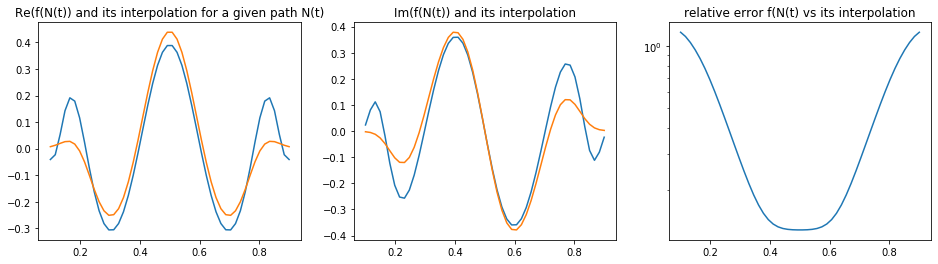

In [107]:
def test_interpolation_N(fx,fN,pN,g,path,ts = np.linspace(0,1)):
    """plots interpolation to real thing in x"""
    fxs = [fx(x) for x in g]
    fNp = lambda N,g=g,fxs=fxs: np.sum([fxs[j]*pN(N,g,j) for j in range(len(g))])
    fig = plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.title("Re(f(N(t)) and its interpolation for a given path N(t)")
    ys = [fN(path(t)) for t in ts]
    yps = [fNp(path(t)) for t in ts]
    plt.plot(ts,np.real(ys))
    plt.plot(ts,np.real(yps))
    plt.subplot(1,3,2)
    plt.title("Im(f(N(t)) and its interpolation")
    plt.plot(ts,np.imag(ys))
    plt.plot(ts,np.imag(yps))
    plt.subplot(1,3,3)
    plt.title("relative error f(N(t) vs its interpolation")
    plt.semilogy(ts,[np.abs((ys[j] - yps[j])/ys[j]) for j in range(len(ts))])
    plt.show()
    return fig

toy_alpha = -0.2
toy_beta = 3.0
#g = np.linspace(0,1,num=5)
#g = interpolation.get_xgrid_Chebyshev_at_log(5,1e-6)
g = interpolation.get_xgrid_linear_at_log(25,1e-7)
path,jac = mellin.get_path_Talbot()
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta), get_toy_pdf_N(toy_alpha,toy_beta),
                    get_Bernstein_interpolators_log_N, g, path,np.linspace(.1,.9));

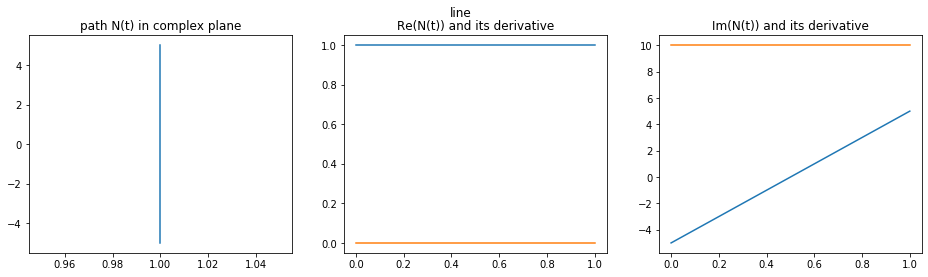

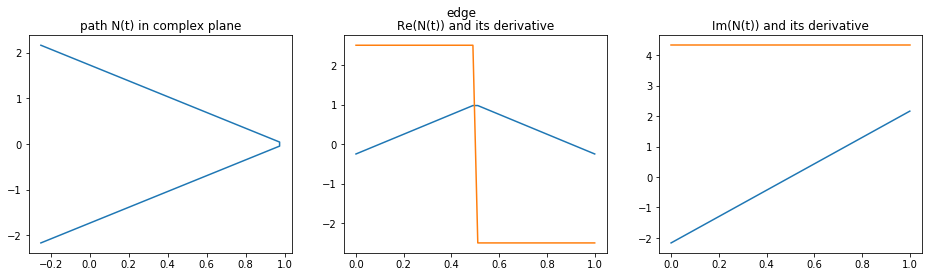

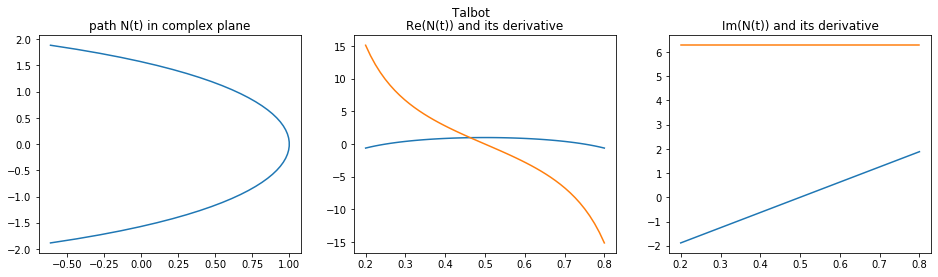

In [17]:
def plot_path(path,jac,plot_ts = np.linspace(0.,1)):
    fig = plt.figure(figsize=(16,4))
    plt.subplot(1,3,1)
    plt.title("path N(t) in complex plane")
    ps = [path(t) for t in plot_ts]
    plt.plot(np.real(ps),np.imag(ps))
    plt.subplot(1,3,2)
    plt.title("Re(N(t)) and its derivative")
    pds = [jac(t) for t in plot_ts]
    plt.plot(plot_ts,np.real(ps))
    plt.plot(plot_ts,np.real(pds))
    plt.subplot(1,3,3)
    plt.title("Im(N(t)) and its derivative")
    plt.plot(plot_ts,np.imag(ps))
    plt.plot(plot_ts,np.imag(pds))
    return fig

p,j = mellin.get_path_line(5)
fig = plot_path(p,j)
fig.suptitle("line")

p,j = mellin.get_path_edge(5)
fig = plot_path(p,j)
fig.suptitle("edge")

p,j = mellin.get_path_Talbot()
fig = plot_path(p,j,np.linspace(.2,.8))
fig.suptitle("Talbot");

/home/felix/Physik/N3PDF/EKO/eko/src/eko/mellin.py:52: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  result = integrate.quad(integrand, cut, 1.0 - cut)


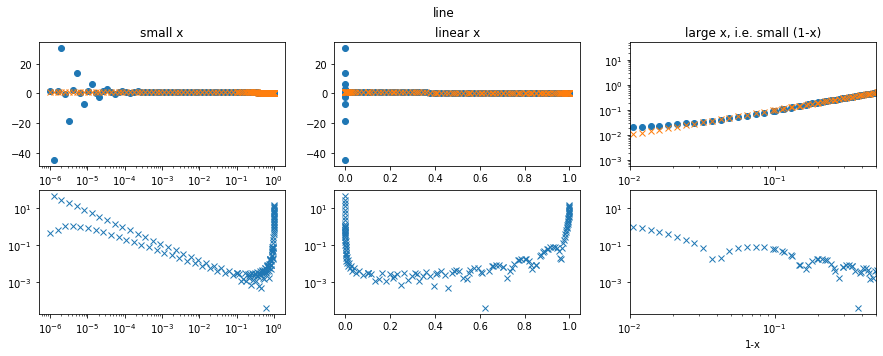

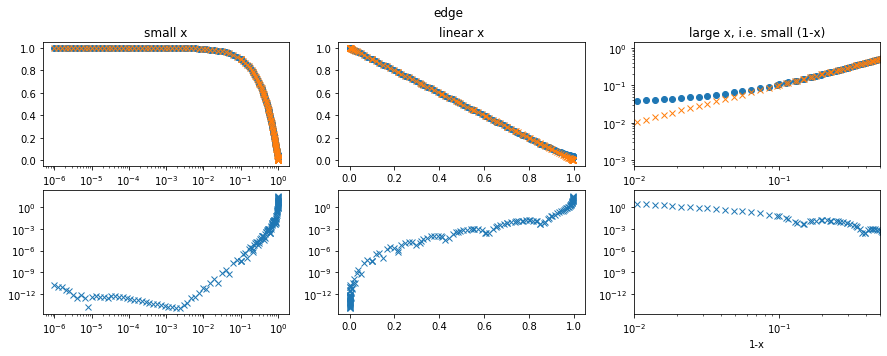

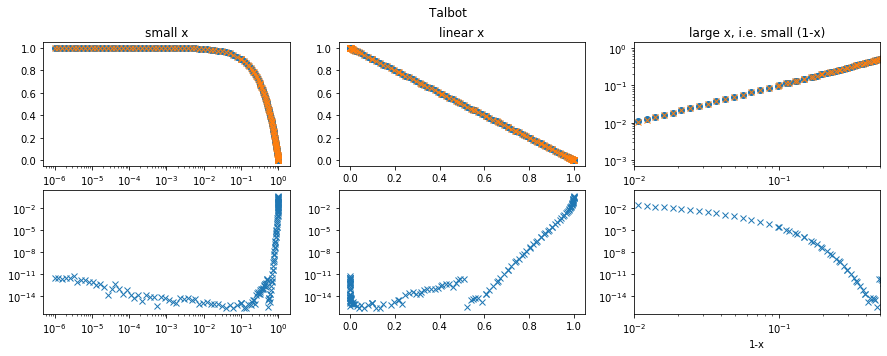

In [19]:
def test_inverse_Mellin_transform(fx,fN,path,jac,cut=0.,xmin=1e-6):
    """plot Mellin integration path and compare numeric inversion to real thing"""
    oMx = 1.0 - np.logspace(-3,np.log10(.9))
    xs = np.append(np.logspace(np.log10(xmin),-1),[np.linspace(0.1,.9),oMx])
    xs = np.sort(xs)
    ys = [fx(x) for x in xs]
    yps = [mellin.inverse_mellin_transform(fN,path,jac,x,cut) for x in xs]
    if isinstance(yps[0],tuple):
        yps = [yp[0] for yp in yps]

    return plot_dist(xs,np.array(yps),np.array(ys))

toy_alpha = 0
toy_beta = 1
p,j = mellin.get_path_line(20)
fig = test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j)
fig.suptitle("line")

p,j = mellin.get_path_edge(20)
fig = test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j)
fig.suptitle("edge")

p,j = mellin.get_path_Talbot()
fig = test_inverse_Mellin_transform(get_toy_pdf_x(toy_alpha,toy_beta),get_toy_pdf_N(toy_alpha,toy_beta),p,j,1e-2)
fig.suptitle("Talbot");

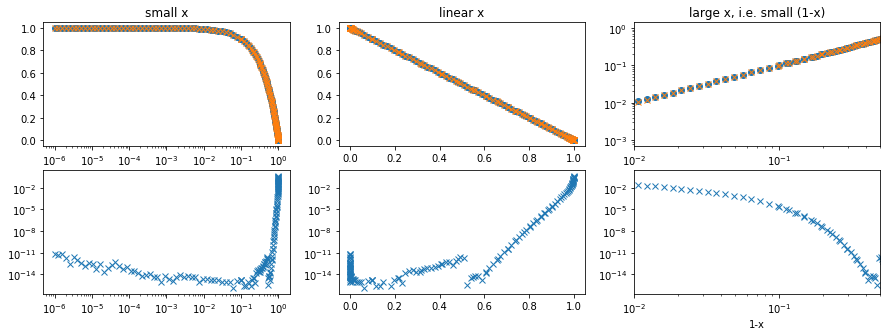

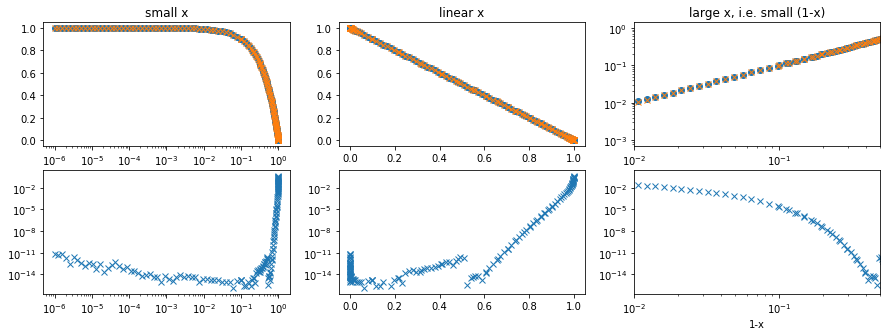

In [20]:
def test_inv_interpolation_x(fx,pN,g,path,jac,cut=0.):
    """compare interpolated numeric inversion to real thing"""
    fxs = [fx(x) for x in g]
    fNp = lambda N,pN=pN,g=g,fxs=fxs: np.sum([fxs[j]*pN(N,g,j) for j in range(len(g))])
    return test_inverse_Mellin_transform(fx,fNp,path,jac,cut)

p,j = mellin.get_path_Talbot()
test_inv_interpolation_x(get_toy_pdf_x(0.,1.),
                     interpolation.get_Lagrange_interpolators_N,
                     [0.,.5,1.],
                     p,j,1e-2
                     )

[0.01253604390908819, 0.1090842587659851, 0.2830581304412209, 0.49999999999999994, 0.716941869558779, 0.890915741234015, 0.9874639560909118]


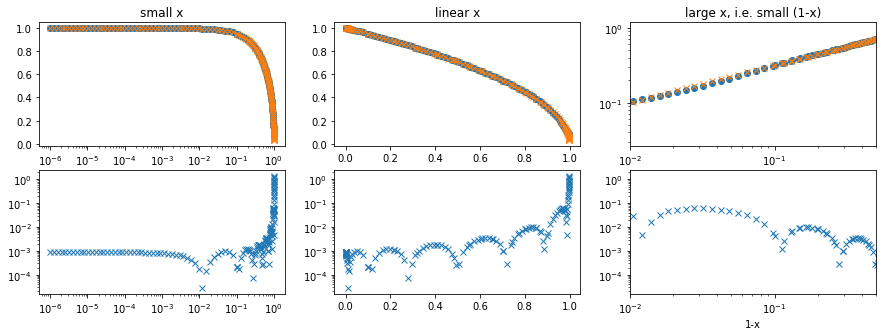

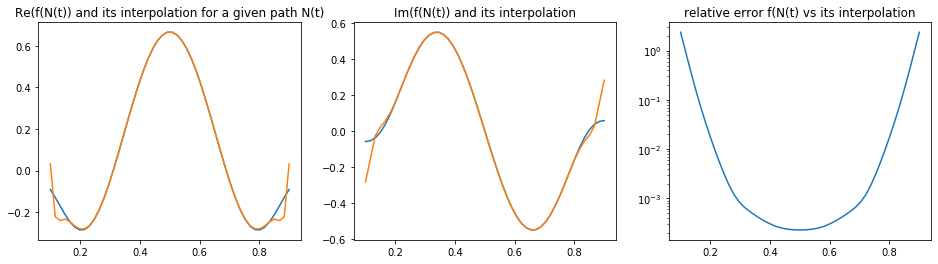

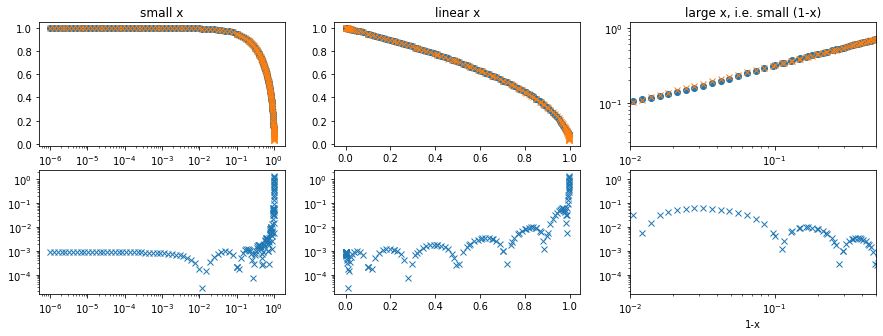

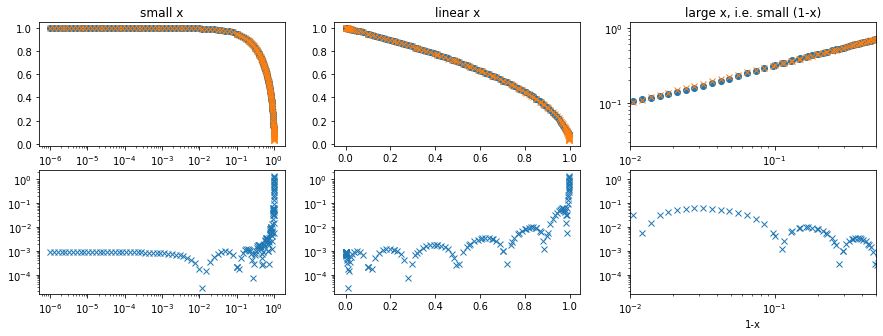

In [21]:
toy_alpha = 0.
toy_beta = .5
#g = np.linspace(0.,1.,num=7)
n_points = 7
g = [.5 - .5*np.cos((2.*j+1)/(2.*n_points)*np.pi) for j in range(n_points)]
print(g)
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_x,
                    g)
p,j = mellin.get_path_Talbot()
#plot_path(p,j,np.linspace(.2,.8))
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_N,
                    g,
                    p,
                    np.linspace(.1,.9))
test_inv_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                         interpolation.get_Lagrange_interpolators_N,
                         g,
                         p,j,
                         1e-2
                        )

[1.189094207336904e-06, 4.513417958554193e-06, 4.992853033786162e-05, 0.000999999999999999, 0.020028628786649537, 0.2215615768765043, 0.8409762606106714]


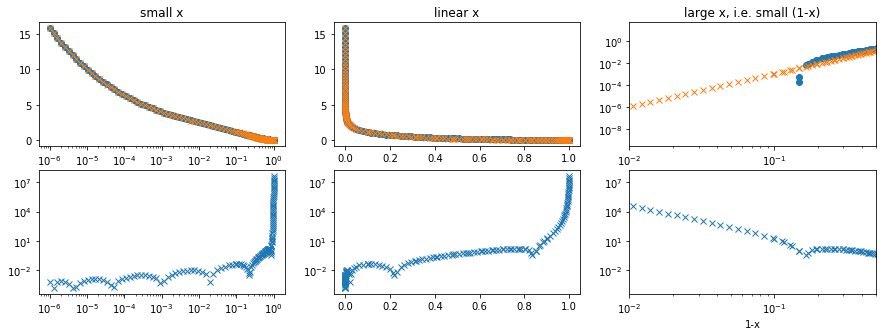

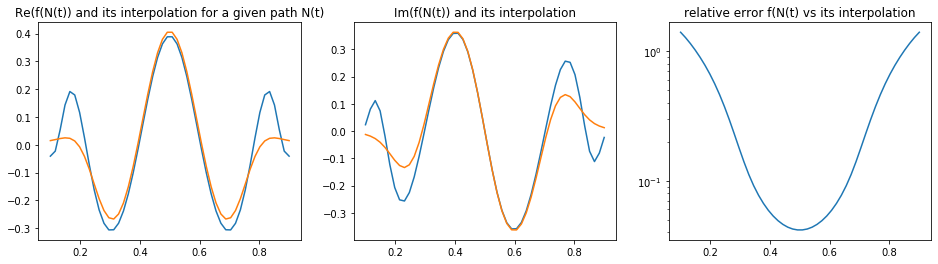

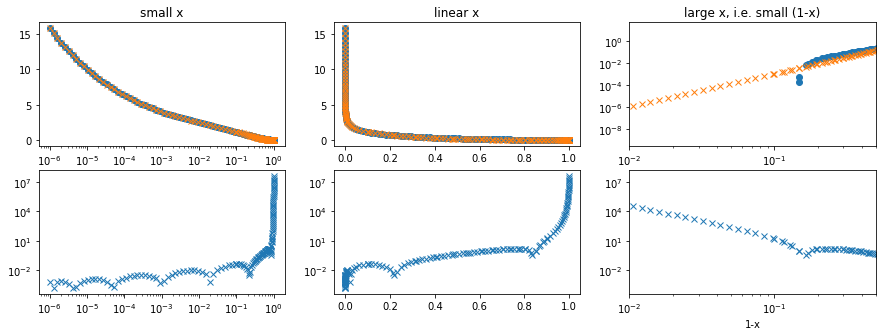

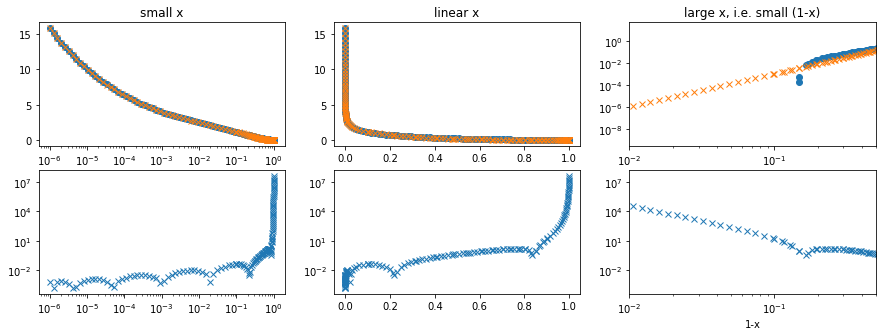

In [22]:
toy_alpha = -0.2
toy_beta = 3.
n_points = 7
g = interpolation.get_xgrid_Chebyshev_at_log(n_points,1e-6)
test_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_log_x,
                    g)
#p,j = get_path_line(10)
p,j = mellin.get_path_Talbot()
#plot_path(p,j,np.linspace(.2,.8))
test_interpolation_N(get_toy_pdf_x(toy_alpha,toy_beta),
                    get_toy_pdf_N(toy_alpha,toy_beta),
                    interpolation.get_Lagrange_interpolators_log_N,
                    g,
                    p,
                    np.linspace(.1,.9))
test_inv_interpolation_x(get_toy_pdf_x(toy_alpha,toy_beta),
                         interpolation.get_Lagrange_interpolators_log_N,
                         g,
                         p,j,
                         1e-2
                        )